# New Mexico, Albuquerque: Top 5 zip codes to invest in

By: Brittney Nitta-Lee

# Project Summary

The goal of this project is to analyze the historical real estate data for Albuquerque, New Mexico, and identify the top 5 zip codes for investment based on forecasted median home prices. A time series modeling approach is employed to predict future values, helping investors make informed decisions.

# Business Understanding

My clients are real estate investors with a focus on properties in King County. Seeking to escape the cold weather, they are interested in exploring investment opportunities in Albuquerque, New Mexico. I will identify five potential zip codes for investment in the area and provide a list of recommendations along with suggested next steps.

## Dataset

The dataset was sourced from Zillow Research and can be accessed [here](https://www.zillow.com/research/data/). The dataset includes 14,723 rows, each representing a zip code, and 272 columns. The data provides median sales for every zip code from April 1996 to April 2018. 


# Load the Data/Filtering for Chosen Zipcodes

In [1]:
# imports
from math import sqrt
from sklearn.metrics import mean_squared_error
import warnings
from pylab import hist, show, xticks
import itertools
from statsmodels.tsa.stattools import adfuller
from matplotlib.pylab import rcParams
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
import warnings
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
df_zillow = pd.read_csv("zillow_data.csv") 
df_zillow.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
df_zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


# Data Preprocessing

The data has 272 columns and 14723 entries. For this project, I want to focus on Albuquerque, so I'll create a new dataframe called `abq_data` to include all data from Albuquerque from `Metro` column. 

In [4]:
abq_data = df_zillow.loc[df_zillow["Metro"] == "Albuquerque"]
abq_data

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
110,95306,87111,Albuquerque,NM,Albuquerque,Bernalillo,111,156900.0,155600.0,154200.0,...,250500,252700,253700,254200,256000,258600,260500,262300,264500,266000
114,95309,87114,Albuquerque,NM,Albuquerque,Bernalillo,115,139000.0,139200.0,139300.0,...,207300,208400,209600,210700,211800,213100,214100,215200,216600,217600
196,95314,87120,Albuquerque,NM,Albuquerque,Bernalillo,197,130900.0,130500.0,130000.0,...,188600,190100,191400,192300,193000,193400,193300,193600,194300,194600
268,95315,87121,Albuquerque,NM,Albuquerque,Bernalillo,269,99900.0,99600.0,99600.0,...,137800,139200,139800,140100,140600,141100,141200,141900,142800,143300
430,95318,87124,Rio Rancho,NM,Albuquerque,Sandoval,431,113200.0,113400.0,113600.0,...,173300,174400,175300,176700,178800,180700,181400,181000,180500,180600
734,95304,87109,Albuquerque,NM,Albuquerque,Bernalillo,735,136100.0,135800.0,135500.0,...,227200,228600,229100,228700,229000,230100,231100,231800,232700,233200
772,95307,87112,Albuquerque,NM,Albuquerque,Bernalillo,773,112200.0,112400.0,112600.0,...,171300,171100,170900,171000,172100,173500,174400,176000,178500,180100
893,95300,87105,South Valley,NM,Albuquerque,Bernalillo,894,96700.0,95800.0,95100.0,...,134700,135400,136200,136900,137600,138200,138400,138500,138600,138400
994,95317,87123,Albuquerque,NM,Albuquerque,Bernalillo,995,114400.0,114700.0,115000.0,...,178300,179600,181000,181700,181800,181600,181200,182200,184300,185300
1006,95305,87110,Albuquerque,NM,Albuquerque,Bernalillo,1007,110500.0,110600.0,110700.0,...,179800,180300,180400,180300,180500,180500,179900,180400,182400,184000


The data contains 28 different zipcodes in Albuquerque. I will drop `RegionID` and `SizeRank` as I don't need those columns for this project. I will also look for any missing data.

In [5]:
abq_data.drop(['RegionID', 'SizeRank'], axis=1, inplace=True)

In [6]:
# checking for null values
abq_data[pd.isna(abq_data).any(axis=1)]

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04


In [7]:
abq_data['CountyName'].unique()

array(['Bernalillo', 'Sandoval', 'Valencia'], dtype=object)

There's three different counties listed in `abq_data`. Next, I'll explore the data and narrow down the zipcodes I want to use for my time series model. 

In [8]:
abq_data2 = abq_data.copy()

# Exploratory Data Analysis

To provide more insightful information to our stakeholders, I will create a new column ROI in the abq_data. This column will represent the total Return on Investment (ROI) for each zip code, which is a more comprehensive measure of profitability. I'll also include the cumulative percent change as these are features to evaluate the peformance of my model.

In [9]:
# create metrics to judge return on investment (ROI)

# total ROI
abq_data['Total_ROI'] = (abq_data['2018-04'] -
                         abq_data['1996-04']) / abq_data['1996-04']

# cumulative percent change
abq_data['Cumulative_Percent_Change'] = (abq_data['2018-04'] / abq_data['1996-04']) * 100

# re-assign to `abq_roi` dataframe with required columns
abq_roi = abq_data.loc[:, ['RegionName', 'City', 'State',                                   'Metro', 'CountyName', 'Total_ROI', 'Cumulative_Percent_Change']]
abq_roi.head()


,RegionName,City,State,Metro,CountyName,Total_ROI,Cumulative_Percent_Change
110,87111,Albuquerque,NM,Albuquerque,Bernalillo,0.695347,169.534736
114,87114,Albuquerque,NM,Albuquerque,Bernalillo,0.565468,156.546763
196,87120,Albuquerque,NM,Albuquerque,Bernalillo,0.486631,148.663102
268,87121,Albuquerque,NM,Albuquerque,Bernalillo,0.434434,143.443443
430,87124,Rio Rancho,NM,Albuquerque,Sandoval,0.595406,159.540636


In [10]:
# Find the top 10 zipcodes in Albuquerque
abq_roi.sort_values('Total_ROI', ascending=False).head(10)

,RegionName,City,State,Metro,CountyName,Total_ROI,Cumulative_Percent_Change
8163,87048,Corrales,NM,Albuquerque,Sandoval,1.204651,220.465116
6420,87122,Albuquerque,NM,Albuquerque,Bernalillo,1.180603,218.060345
3005,87106,Albuquerque,NM,Albuquerque,Bernalillo,1.102404,210.240427
10088,87043,Placitas,NM,Albuquerque,Sandoval,0.903690,190.369037
7089,87104,Albuquerque,NM,Albuquerque,Bernalillo,0.750883,175.088339
734,87109,Albuquerque,NM,Albuquerque,Bernalillo,0.713446,171.344600
8314,87059,Tijeras,NM,Albuquerque,Bernalillo,0.702817,170.281690
110,87111,Albuquerque,NM,Albuquerque,Bernalillo,0.695347,169.534736
2698,87107,Albuquerque,NM,Albuquerque,Bernalillo,0.684394,168.439407
1027,87108,Albuquerque,NM,Albuquerque,Bernalillo,0.666667,166.666667


New Mexico's largest county is Bernalillo, which contains 47 zipcodes. In comparison, Sandoval county only contains 18 zipcodes. Interestingly, despite its smaller size, the median household income in Sandoval county is $10,000 higher than that of Bernalillo county.

In [11]:
abq_data.sort_values

<bound method DataFrame.sort_values of        RegionName          City State        Metro  CountyName   1996-04  \
110         87111   Albuquerque    NM  Albuquerque  Bernalillo  156900.0   
114         87114   Albuquerque    NM  Albuquerque  Bernalillo  139000.0   
196         87120   Albuquerque    NM  Albuquerque  Bernalillo  130900.0   
268         87121   Albuquerque    NM  Albuquerque  Bernalillo   99900.0   
430         87124    Rio Rancho    NM  Albuquerque    Sandoval  113200.0   
734         87109   Albuquerque    NM  Albuquerque  Bernalillo  136100.0   
772         87112   Albuquerque    NM  Albuquerque  Bernalillo  112200.0   
893         87105  South Valley    NM  Albuquerque  Bernalillo   96700.0   
994         87123   Albuquerque    NM  Albuquerque  Bernalillo  114400.0   
1006        87110   Albuquerque    NM  Albuquerque  Bernalillo  110500.0   
1027        87108   Albuquerque    NM  Albuquerque  Bernalillo   96300.0   
1628        87031     Los Lunas    NM  Albuquerqu

# Visualization

Now that I have selected the top 10 zipcodes in Albuquerque, I'll create a bar graph to see the growth percentage.

In [12]:
# formatting for the rest of our visualizations
font = {'family': 'DejaVu Sans',
        'weight': 'bold',
        'size': 22}

plt.rc('font', **font)

Text(0, 0.5, 'Growth Percentage')

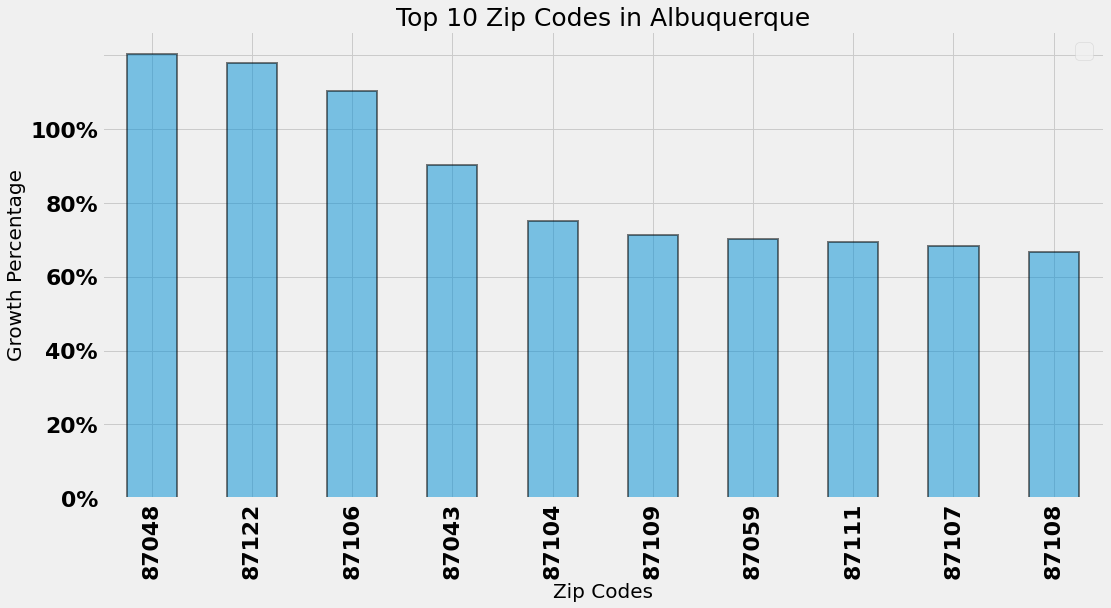

In [13]:
# Sort values by Total_ROI 
abq_roi_sorted = abq_roi.sort_values(by='Total_ROI', ascending=False)
ax = abq_roi_sorted.head(10).plot.bar(x='RegionName', y='Total_ROI', figsize=(
    16, 8), alpha=0.5, edgecolor="black", linewidth=2)
plt.title('Top 10 Zip Codes in Albuquerque', fontsize=25)
plt.legend('')
ax.set_yticklabels(["0%", "20%", "40%", "60%", "80%", "100%"])
plt.xlabel('Zip Codes', fontsize=20)
plt.ylabel('Growth Percentage', fontsize=20)

In [14]:
# Create new dataframe for top 10 zipcodes in Albuquerque 
abq_10 = abq_roi.sort_values(by='Total_ROI', ascending=False).head(10)
abq_10

,RegionName,City,State,Metro,CountyName,Total_ROI,Cumulative_Percent_Change
8163,87048,Corrales,NM,Albuquerque,Sandoval,1.204651,220.465116
6420,87122,Albuquerque,NM,Albuquerque,Bernalillo,1.180603,218.060345
3005,87106,Albuquerque,NM,Albuquerque,Bernalillo,1.102404,210.240427
10088,87043,Placitas,NM,Albuquerque,Sandoval,0.903690,190.369037
7089,87104,Albuquerque,NM,Albuquerque,Bernalillo,0.750883,175.088339
734,87109,Albuquerque,NM,Albuquerque,Bernalillo,0.713446,171.344600
8314,87059,Tijeras,NM,Albuquerque,Bernalillo,0.702817,170.281690
110,87111,Albuquerque,NM,Albuquerque,Bernalillo,0.695347,169.534736
2698,87107,Albuquerque,NM,Albuquerque,Bernalillo,0.684394,168.439407
1027,87108,Albuquerque,NM,Albuquerque,Bernalillo,0.666667,166.666667


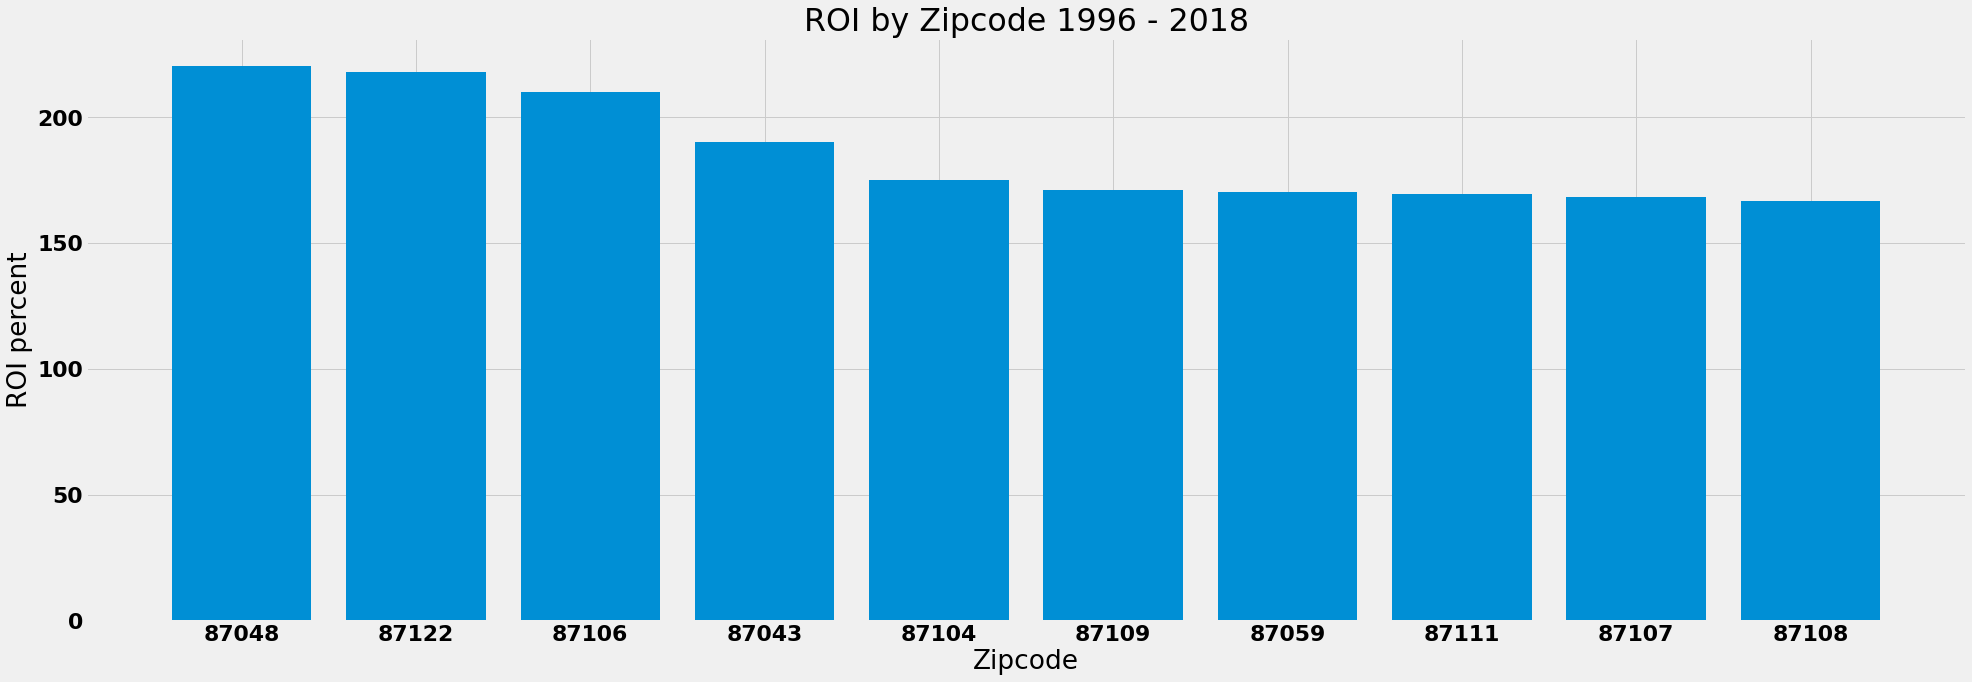

In [15]:
abq_10['RegionName'] = abq_10['RegionName'].astype(str)

# Plotting the historical data 
fig, ax = plt.subplots(figsize=(30,10))
plt.bar(abq_10.RegionName, abq_10['Cumulative_Percent_Change'])
plt.title('ROI by Zipcode 1996 - 2018')
plt.xlabel('Zipcode')
plt.ylabel('ROI percent')
plt.show()

This graph shows the top 10 zipcodes with the highest ROI over the period of 1996 to 2018. There's subtle changes between 87101 and 87108. 

In [16]:
# list of top 5 zipcodes
region_list = ['87048', '87122', '87106', '87043', '87104']

# filter rows with desired RegionNames
abq_top_5 = abq_data[abq_data['RegionName'].isin(region_list)]

abq_top_5 = abq_top_5.drop(columns=['Total_ROI', 'Cumulative_Percent_Change'])

# display new dataframe
abq_top_5.head()

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
3005,87106,Albuquerque,NM,Albuquerque,Bernalillo,112300.0,112300.0,112400.0,112400.0,112400.0,...,221100,221500,221000,221400,223700,227500,230500,232700,234700,236100
6420,87122,Albuquerque,NM,Albuquerque,Bernalillo,232000.0,232000.0,232000.0,232200.0,232400.0,...,504200,499700,497500,499600,503100,505700,508200,509300,508200,505900
7089,87104,Albuquerque,NM,Albuquerque,Bernalillo,113200.0,113300.0,113400.0,113500.0,113600.0,...,177400,179300,181600,184100,186500,188800,190300,192100,195300,198200
8163,87048,Corrales,NM,Albuquerque,Sandoval,193500.0,193700.0,193800.0,194000.0,194200.0,...,412300,411700,408900,408300,411400,414400,415000,418200,423200,426600
10088,87043,Placitas,NM,Albuquerque,Sandoval,222200.0,222400.0,222700.0,223100.0,223600.0,...,393700,393600,392600,395000,402400,410900,416700,419400,421000,423000


In [17]:
abq_top_5

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
3005,87106,Albuquerque,NM,Albuquerque,Bernalillo,112300.0,112300.0,112400.0,112400.0,112400.0,...,221100,221500,221000,221400,223700,227500,230500,232700,234700,236100
6420,87122,Albuquerque,NM,Albuquerque,Bernalillo,232000.0,232000.0,232000.0,232200.0,232400.0,...,504200,499700,497500,499600,503100,505700,508200,509300,508200,505900
7089,87104,Albuquerque,NM,Albuquerque,Bernalillo,113200.0,113300.0,113400.0,113500.0,113600.0,...,177400,179300,181600,184100,186500,188800,190300,192100,195300,198200
8163,87048,Corrales,NM,Albuquerque,Sandoval,193500.0,193700.0,193800.0,194000.0,194200.0,...,412300,411700,408900,408300,411400,414400,415000,418200,423200,426600
10088,87043,Placitas,NM,Albuquerque,Sandoval,222200.0,222400.0,222700.0,223100.0,223600.0,...,393700,393600,392600,395000,402400,410900,416700,419400,421000,423000


# Reshape from Wide to Long Format

Now that I have the data that I want to use, I'll reshape the data from a wideformat to a long format. The `abq_data` contains the wide format dataset. 

In [18]:
def melt_data(df):
   # Melt data into wide version
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    # Create new column as datetime variable 
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    # Remove rows with missing values 
    melted = melted.dropna(subset=['value'])
    # set `time` as index 
    melted.set_index('time', inplace=True)
    return melted.groupby('time').aggregate({'value':'mean'})

In [19]:
# Create new data frame for zipcodes
abq_zip = [zip_code for zip_code in abq_10['RegionName']]

In [20]:
abq_zip

['87048',
 '87122',
 '87106',
 '87043',
 '87104',
 '87109',
 '87059',
 '87111',
 '87107',
 '87108']

# Final top 10 zipcodes 

I want to create a visualization for the top 10 zipcodes. The visualization helps with detecting and trends or patterns.

In [21]:
abq_df = pd.DataFrame()
for i in abq_top_5['RegionName']:
    x = melt_data(abq_top_5[abq_top_5['RegionName'] == i])
    abq_df  = pd.concat([abq_df, x], axis=1)
    abq_df .rename(columns = {'value':i}, inplace = True)
    
# Display results
abq_df.head(10)

,87106,87122,87104,87048,87043
time,,,,,
1996-04-01,112300.0,232000.0,113200.0,193500.0,222200.0
1996-05-01,112300.0,232000.0,113300.0,193700.0,222400.0
1996-06-01,112400.0,232000.0,113400.0,193800.0,222700.0
1996-07-01,112400.0,232200.0,113500.0,194000.0,223100.0
1996-08-01,112400.0,232400.0,113600.0,194200.0,223600.0
1996-09-01,112400.0,232800.0,113700.0,194400.0,224100.0
1996-10-01,112500.0,233200.0,113800.0,194700.0,224700.0
1996-11-01,112600.0,233800.0,114000.0,194700.0,225000.0
1996-12-01,112800.0,234500.0,114100.0,194600.0,224900.0


To make it easier to analyze and visualize the data, I'm going to resample the time series to a monthly frequency with the start of each month as the observation point. This will aggregate the data for each month and create a new dataframe with the data for the first day of each month. This is particularly useful for forecasting and filling in any gaps in the data.

In [22]:
abq_df = abq_df.asfreq('MS')

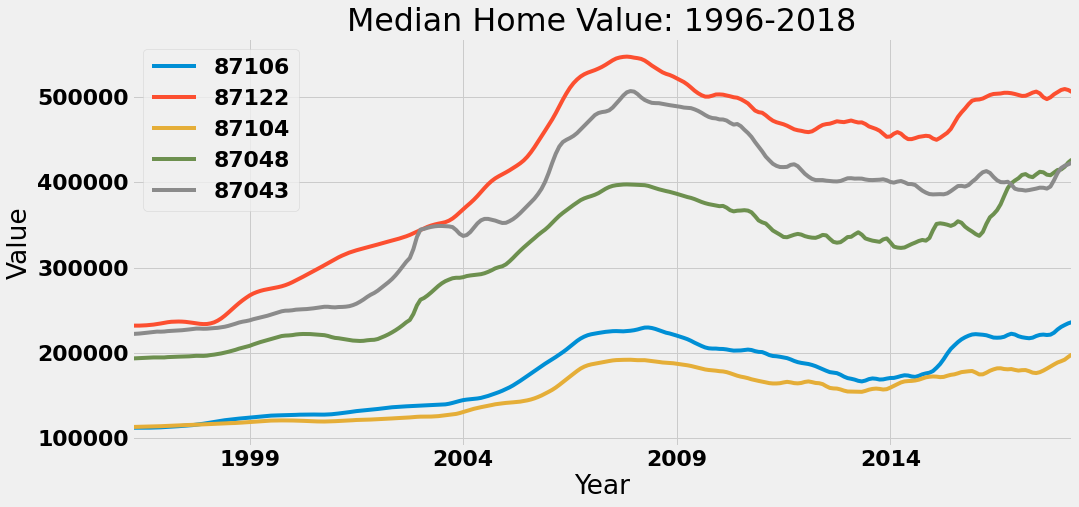

In [23]:
abq_df.plot(figsize=(15, 7))
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Median Home Value: 1996-2018')
plt.show();

Now we can see our training data and the testing data. 80% of our data is in the train and 20% of the data is in test. It looks like the split point is in 2014. The trend line has an upward pattern up until 2008 where you can see a downward trend. This is due to the Great Recession. 
The "Subprime Mortgage Crisis" was a period of time (2007 to 2010) when there was an increase in the number of high-risk mortgages that went into default and caused a ripple effect on the housing market and broader economy. This is important to highlight as I am not inlcuding this data into my modeling. 
<br>[More information about the Subprime Mortgage Crisis](https://www.history.com/topics/21st-century/recession)</br>

# Train Validation  Split and Naive Model

I'll create a naive model by shifting the `train` data by one day to create a simple baseline model for comparison with my SARIMAX model. The naive model predicts that the current value is the same as the value from the previous day and does not take into account any patterns or trends in the data. The purpose of this model is to establish a baseline performance metric, which is the root mean squared error (RMSE). 

In [24]:
# Create new dataframe with datapoints beginning in 2011
abq_df_new = abq_df['2011-01-01':]

In [25]:
# Get a list of unique zipcodes (column names)
unique_zipcodes = abq_df_new.columns

# Initialize an empty dictionary to store the RMSE values for each zipcode
rmse_dict = {}

# Define the train-test split ratio
split_ratio = 0.8

# Loop through the unique zipcodes
for zipcode in unique_zipcodes:
    # Get the data for the current zipcode
    data = abq_df_new[zipcode]
    
    # Calculate the index for the train-test split
    cutoff = int(len(data) * split_ratio)

    # Split the data into train and test sets
    train = data[:cutoff]
    test = data[cutoff:]

    # Shift the train data by 1 time step to create the naive model predictions
    naive_predictions = train.shift(1)

    # Calculate the RMSE between the actual values and the naive model predictions (excluding the first value due to NaN in naive_predictions)
    rmse_naive_train = np.sqrt(np.mean((train[1:] - naive_predictions[1:])**2))

    # Shift the test data by 1 time step to create the naive model predictions
    naive_predictions_test = test.shift(1)

    # Calculate the RMSE between the actual values and the naive model predictions (excluding the first value due to NaN in naive_predictions)
    rmse_naive_test = np.sqrt(np.mean((test[1:] - naive_predictions_test[1:])**2))

    # Add the RMSE values to the dictionary with the zipcode as the key
    rmse_dict[zipcode] = {'train': rmse_naive_train, 'test': rmse_naive_test}

# Print the baseline RMSE values for each zipcode
print('Baseline RMSE values for each zipcode:')
for zipcode, rmse_values in rmse_dict.items():
    print(f'Zipcode {zipcode}: Train RMSE = {rmse_values["train"]:.2f}, Test RMSE = {rmse_values["test"]:.2f}')


Baseline RMSE values for each zipcode:
Zipcode 87106: Train RMSE = 1992.74, Test RMSE = 1763.69
Zipcode 87122: Train RMSE = 2483.10, Test RMSE = 2151.74
Zipcode 87104: Train RMSE = 1084.01, Test RMSE = 1848.21
Zipcode 87048: Train RMSE = 3602.07, Test RMSE = 2825.51
Zipcode 87043: Train RMSE = 2222.06, Test RMSE = 3517.35


Now that I have my baseline RMSE for each zipode, I'll use the RMSE as a baseline to evaluate my models.

# SARIMAX Modeling

Now that I have my baseline model, I will use a SARIMA model to forecast the median value of the top 5 zipcodes in Albuquerque. The top five zipcodes will have individual predictions and forecast results. I will evaluate each model by calculate the Root Mean Squared Error (RMSE).
I will also include the 95% confidence interval, which will give a range of values within the true future value is likely to fall, with of course, 95% confidence. 

I chose a SARIMAX model for forecasting the top 5 zipcodes for multiple reasons: 
1. Seasonality - Real Estate prices exhibit seasonal patterns.
2. Autoregressive and Moving Average Components - SARIMAX is an extension of the ARIMA model, which combines AR and moving average components. 
3. Flexibility - Specifiy different orders for AR, MA, Seasonal, which allows for fine-tuning the model to better fit the data for each zipcode. 
4. Interpretability - Interpretable results.

## Albuquerque, New Mexico 87106

In [26]:
# Define train and validation datasets based 20% and 80% 
training_data = abq_df_new[87106][:cutoff]
validation_data = abq_df_new[87106][cutoff:]

# Define the range of parameters for p, d, q, P, D, Q, and s
p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = 12  # monthly data

# Generate a list of all possible combinations of parameters
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s) for x in itertools.product(P, D, Q)]

# Initialize variables to store the best parameters and the lowest RMSE
best_params = (0, 0, 0, 0, 0, 0, 0)
lowest_rmse = float('inf')

# Loop through all possible combinations of parameters
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            # Fit a SARIMAX model with the current combination of parameters
            model = sm.tsa.statespace.SARIMAX(training_data,
                                              order=param,
                                              seasonal_order=param_seasonal,
                                              enforce_stationarity=False,
                                              enforce_invertibility=False).fit()
            
            # Make predictions on the validation data
            predictions = model.predict(start=validation_data.index[0], end=validation_data.index[-1], typ='levels')

            # Calculate the RMSE of the predictions
            rmse = np.sqrt(np.mean((predictions - validation_data)**2))

            # Update the best parameters and lowest RMSE if the current RMSE is lower
            if rmse < lowest_rmse:
                best_params = (param, param_seasonal)
                lowest_rmse = rmse

        except ValueError:  # skip combinations that fail to converge or produce errors
            continue

print(f'Best parameters: {best_params}')
print(f'Lowest RMSE: {lowest_rmse:.2f}')

Best parameters: ((1, 0, 0), (0, 0, 0, 12))
Lowest RMSE: 4536.00


The root mean squared error(RMSE) is $4,536, which represents the average difference between the actual data points and the predictions made by the SARIMAX model. This is higher than our baseline model and it indicates that the model may not be adequately capturing the data's structure. 

Albuquerque, NM, 87106:
95% confidence: $236629.0 and $293381.0
Confidence range: $56752.0


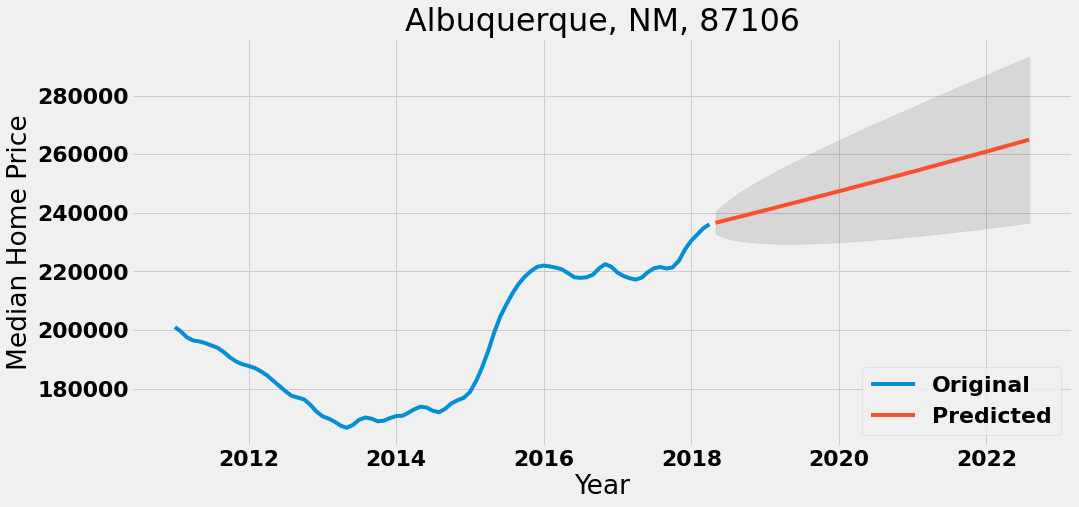

In [27]:
#Define SARIMAX model and fit data save as sarima_mod1
sarima_mod1 = sm.tsa.statespace.SARIMAX(abq_df_new[87106],
                                        order=(1, 0, 0), 
                                        seasonal_order=(0, 0, 0, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False).fit()
# Forecast 52 months into the future (4 years)
forecast1 = sarima_mod1.get_forecast(steps=52).summary_frame()

# Calculate the mean of the last week of the forecast as the predicted value
forecast1_mean = round(forecast1['mean'][51])

#Calculate the difference between lower and upper 95% confidence intervals of the last week of the forecast 
low_int1 =  round(forecast1['mean_ci_lower'][51])
high_int1 = round(forecast1['mean_ci_upper'][51])

#Calculate the difference between the upper and lower confidence intervals 
ci_delta1 = round(high_int1 - low_int1)

# Print predicted value and confidence intervals
print(f'Albuquerque, NM, 87106:')   
print(f'95% confidence: ${low_int1} and ${high_int1}')
print(f'Confidence range: ${ci_delta1}')

# Plot the original data and predicted values with confidence intervals
fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(abq_df_new[87106])
plt.plot(forecast1['mean'])
ax.fill_between(forecast1.index, forecast1['mean_ci_lower'], 
                    forecast1['mean_ci_upper'], color='k', alpha=0.1)
plt.title('Albuquerque, NM, 87106')
plt.legend(['Original','Predicted'], loc='lower right')
plt.xlabel('Year')
plt.ylabel('Median Home Price')
plt.show()

The result shows the forecast for the median home price in zipcode 87106. The 95% confidence interval is a measure of uncertainty around the predicted value. The 95% confidence interval is between $236,629 and $293,381. This means that based on the model's predictions, there is a 95% probability that the true median home price will fall within this range. The confidence range is $56,752 which is the difference between the upper and lower bounds of the confidence interval. 

## Albuquerque, New Mexico 87122

In [28]:
# Define train and validation datasets based 20% and 80% 
training_data2 = abq_df_new[87122][:cutoff]
validation_data2 = abq_df_new[87122][cutoff:]

# Define the range of parameters for p, d, q, P, D, Q, and s
p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = 12  # monthly data

# Generate a list of all possible combinations of parameters
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s) for x in itertools.product(P, D, Q)]

# Initialize variables to store the best parameters and the lowest RMSE
best_params = (0, 0, 0, 0, 0, 0, 0)
lowest_rmse = float('inf')

# Loop through all possible combinations of parameters
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            # Fit a SARIMAX model with the current combination of parameters
            model2 = sm.tsa.statespace.SARIMAX(training_data2,
                                              order=param,
                                              seasonal_order=param_seasonal,
                                              enforce_stationarity=False,
                                              enforce_invertibility=False).fit()
            
            # Make predictions on the validation data
            predictions2 = model2.predict(start=validation_data2.index[0], end=validation_data2.index[-1], typ='levels')

            # Calculate the RMSE of the predictions
            rmse2 = np.sqrt(np.mean((predictions2 - validation_data2)**2))

            # Update the best parameters and lowest RMSE if the current RMSE is lower
            if rmse2 < lowest_rmse:
                best_params = (param, param_seasonal)
                lowest_rmse = rmse2

        except ValueError:  # skip combinations that fail to converge or produce errors
            continue

print(f'Best parameters: {best_params}')
print(f'Lowest RMSE: {lowest_rmse:.2f}')

Best parameters: ((0, 1, 1), (0, 0, 1, 12))
Lowest RMSE: 3155.22


The RMSE is a little closer to our baseline model. Due to the computational time, I'll leave the parameters to 0,2. 

Albuquerque, NM, 87122:
95% confidence: $236629.0 and $293381.0
Confidence range: $56752.0


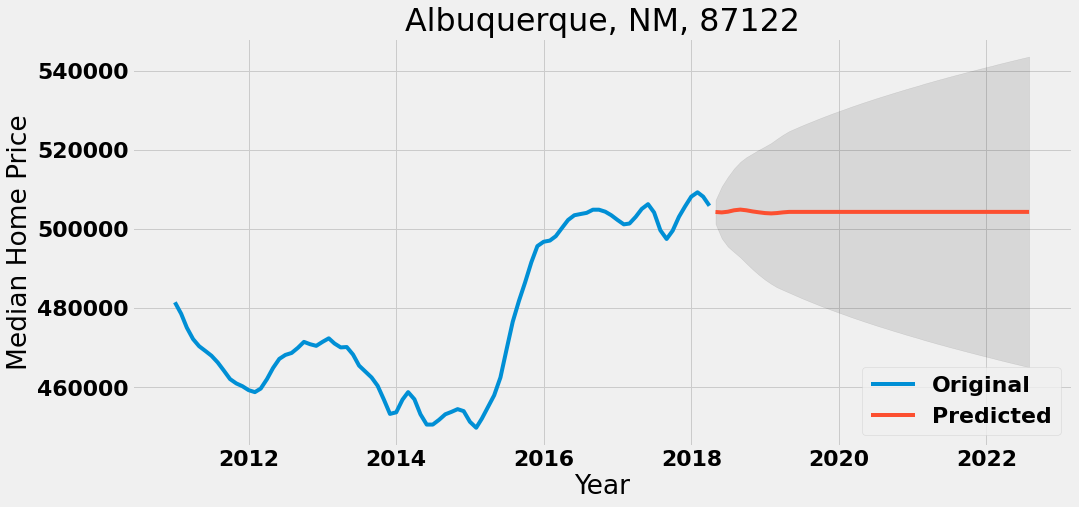

In [29]:
#Define SARIMAX model and fit data save as sarima_mod1
sarima_mod2 = sm.tsa.statespace.SARIMAX(abq_df_new[87122],
                                        order=(0, 1, 1), 
                                        seasonal_order=(0, 0, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False).fit()
# # Forecast 52 months into the future (4 years)
forecast2 = sarima_mod2.get_forecast(steps=52).summary_frame()

# Calculate the mean of the last week of the forecast as the predicted value
forecast2_mean = round(forecast2['mean'][51])

#Calculate the difference between lower and upper 95% confidence intervals of the last week of the forecast 
low_int2 =  round(forecast2['mean_ci_lower'][51])
high_int2 = round(forecast2['mean_ci_upper'][51])

#Calculate the difference between the upper and lower confidence intervals 
ci_delta2 = round(high_int2 - low_int2)

# Print predicted value and confidence intervals
print(f'Albuquerque, NM, 87122:')   
print(f'95% confidence: ${low_int1} and ${high_int1}')
print(f'Confidence range: ${ci_delta1}')

# Plot the original data and predicted values with confidence intervals
fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(abq_df_new[87122])
plt.plot(forecast2['mean'])
ax.fill_between(forecast2.index, forecast2['mean_ci_lower'], 
                    forecast2['mean_ci_upper'], color='k', alpha=0.1)
plt.title('Albuquerque, NM, 87122')
plt.legend(['Original','Predicted'], loc='lower right')
plt.xlabel('Year')
plt.ylabel('Median Home Price')
plt.show()

Zipcode 87122 has the same results as 87106. Let's move on and see the results of our other zipcodes.

# Albuquerque, NM, 87104

In [30]:
# Define train and validation datasets based 20% and 80% 
training_data3 = abq_df_new[87104][:cutoff]
validation_data3 = abq_df_new[87104][cutoff:]

# Define the range of parameters for p, d, q, P, D, Q, and s
p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = 12  # monthly data

# Generate a list of all possible combinations of parameters
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s) for x in itertools.product(P, D, Q)]

# Initialize variables to store the best parameters and the lowest RMSE
best_params = (0, 0, 0, 0, 0, 0, 0)
lowest_rmse = float('inf')

# Loop through all possible combinations of parameters
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            # Fit a SARIMAX model with the current combination of parameters
            model3 = sm.tsa.statespace.SARIMAX(training_data3,
                                              order=param,
                                              seasonal_order=param_seasonal,
                                              enforce_stationarity=False,
                                              enforce_invertibility=False).fit()
            
            # Make predictions on the validation data
            predictions3 = model3.predict(start=validation_data3.index[0], end=validation_data3.index[-1], typ='levels')

            # Calculate the RMSE of the predictions
            rmse3 = np.sqrt(np.mean((predictions3 - validation_data3)**2))

            # Update the best parameters and lowest RMSE if the current RMSE is lower
            if rmse3 < lowest_rmse:
                best_params = (param, param_seasonal)
                lowest_rmse = rmse3

        except ValueError:  # skip combinations that fail to converge or produce errors
            continue

print(f'Best parameters: {best_params}')
print(f'Lowest RMSE: {lowest_rmse:.2f}')

Best parameters: ((1, 0, 1), (1, 0, 1, 12))
Lowest RMSE: 5235.02


The RMSE is a lot higher than our baseline model. 

Albuquerque, NM, 87104:
95% confidence: $236629.0 and $293381.0
Confidence range: $56752.0


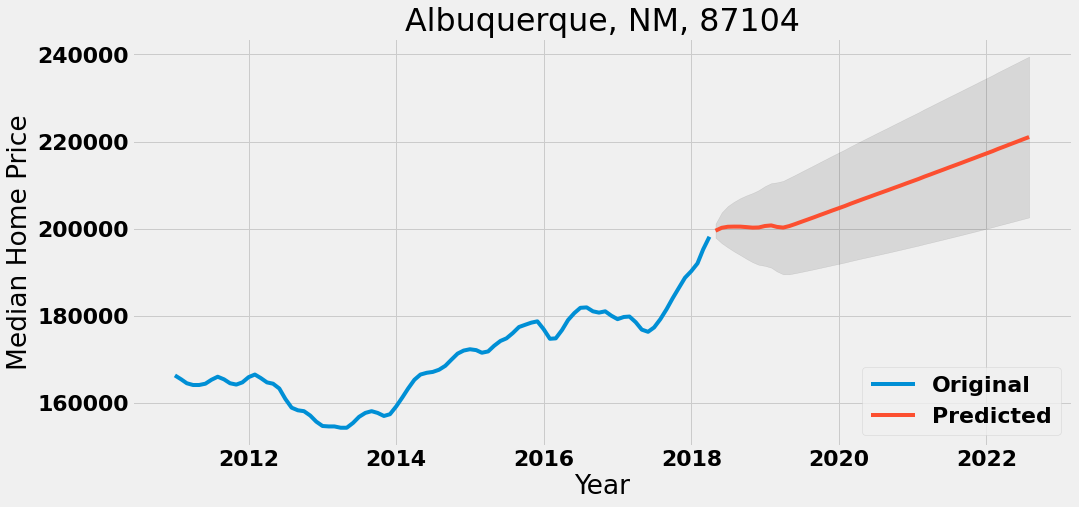

In [31]:
#Define SARIMAX model and fit data save as sarima_mod1
sarima_mod3 = sm.tsa.statespace.SARIMAX(abq_df_new[87104],
                                        order=(1, 0, 1), 
                                        seasonal_order=(1, 0, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False).fit()
# Forecast 52 months into the future (4 years)
forecast3 = sarima_mod3.get_forecast(steps=52).summary_frame()

# Calculate the mean of the last week of the forecast as the predicted value
forecast3_mean = round(forecast3['mean'][51])

#Calculate the difference between lower and upper 95% confidence intervals of the last week of the forecast 
low_int3 =  round(forecast3['mean_ci_lower'][51])
high_int3 = round(forecast3['mean_ci_upper'][51])

#Calculate the difference between the upper and lower confidence intervals 
ci_delta3 = round(high_int3 - low_int3)

# Print predicted value and confidence intervals
print(f'Albuquerque, NM, 87104:')   
print(f'95% confidence: ${low_int1} and ${high_int1}')
print(f'Confidence range: ${ci_delta1}')

# Plot the original data and predicted values with confidence intervals
fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(abq_df_new[87104])
plt.plot(forecast3['mean'])
ax.fill_between(forecast3.index, forecast3['mean_ci_lower'], 
                    forecast3['mean_ci_upper'], color='k', alpha=0.1)
plt.title('Albuquerque, NM, 87104')
plt.legend(['Original','Predicted'], loc='lower right')
plt.xlabel('Year')
plt.ylabel('Median Home Price')
plt.show()

This also gave the same results as the previous zipcodes. 

# Albuquerque, NM, 87048

In [32]:
# Define train and validation datasets based 20% and 80% 
training_data4 = abq_df_new[87048][:cutoff]
validation_data4 = abq_df_new[87048][cutoff:]

# Define the range of parameters for p, d, q, P, D, Q, and s
p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = 12  # monthly data

# Generate a list of all possible combinations of parameters
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s) for x in itertools.product(P, D, Q)]

# Initialize variables to store the best parameters and the lowest RMSE
best_params = (0, 0, 0, 0, 0, 0, 0)
lowest_rmse = float('inf')

# Loop through all possible combinations of parameters
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            # Fit a SARIMAX model with the current combination of parameters
            model4 = sm.tsa.statespace.SARIMAX(training_data4,
                                              order=param,
                                              seasonal_order=param_seasonal,
                                              enforce_stationarity=False,
                                              enforce_invertibility=False).fit()
            
            # Make predictions on the validation data
            predictions4 = model4.predict(start=validation_data4.index[0], end=validation_data4.index[-1], typ='levels')

            # Calculate the RMSE of the predictions
            rmse4 = np.sqrt(np.mean((predictions4 - validation_data4)**2))

            # Update the best parameters and lowest RMSE if the current RMSE is lower
            if rmse4 < lowest_rmse:
                best_params = (param, param_seasonal)
                lowest_rmse = rmse4

        except ValueError:  # skip combinations that fail to converge or produce errors
            continue

print(f'Best parameters: {best_params}')
print(f'Lowest RMSE: {lowest_rmse:.2f}')

Best parameters: ((1, 0, 1), (1, 0, 0, 12))
Lowest RMSE: 4128.81


The RMSE is $1,000 higher than our baseline. Again, there are different approaches such as grid search that I could use.

Albuquerque, NM, 87048:
95% confidence: $236629.0 and $293381.0
Confidence range: $56752.0


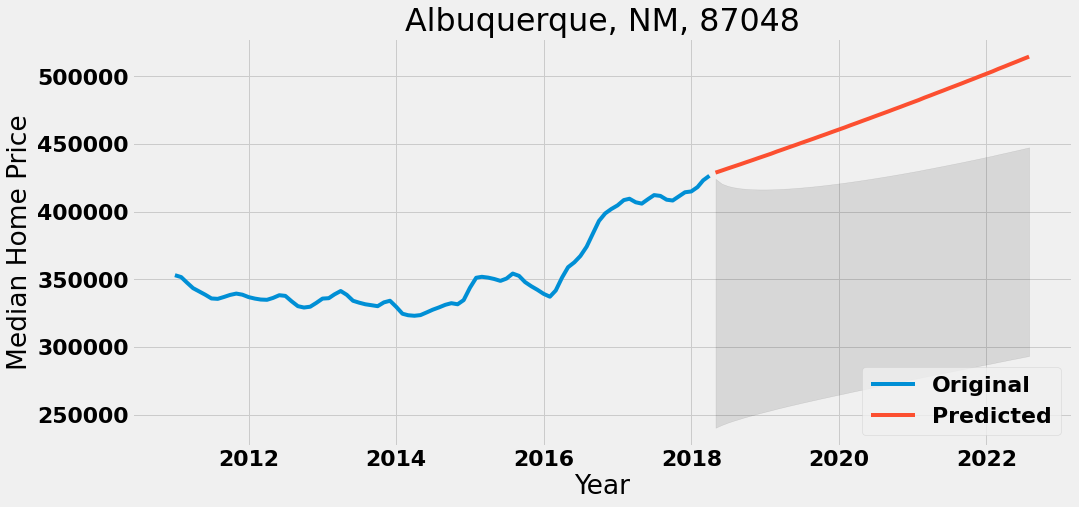

In [33]:
#Define SARIMAX model and fit data save as sarima_mod1
sarima_mod4 = sm.tsa.statespace.SARIMAX(abq_df_new[87048],
                                        order=(1, 0, 1), 
                                        seasonal_order=(1, 0, 0, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False).fit()
# Forecast 52 months into the future (4 years)
forecast4 = sarima_mod4.get_forecast(steps=52).summary_frame()

# Calculate the mean of the last week of the forecast as the predicted value
forecast4_mean = round(forecast4['mean'][51])

#Calculate the difference between lower and upper 95% confidence intervals of the last week of the forecast 
low_int4 =  round(forecast4['mean_ci_lower'][51])
high_int4 = round(forecast4['mean_ci_upper'][51])

#Calculate the difference between the upper and lower confidence intervals 
ci_delta4 = round(high_int4 - low_int4)

# Print predicted value and confidence intervals
print(f'Albuquerque, NM, 87048:')   
print(f'95% confidence: ${low_int1} and ${high_int1}')
print(f'Confidence range: ${ci_delta1}')

# Plot the original data and predicted values with confidence intervals
fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(abq_df_new[87048])
plt.plot(forecast4['mean'])
ax.fill_between(forecast4.index, forecast4['mean_ci_lower'], 
                    forecast1['mean_ci_upper'], color='k', alpha=0.1)
plt.title('Albuquerque, NM, 87048')
plt.legend(['Original','Predicted'], loc='lower right')
plt.xlabel('Year')
plt.ylabel('Median Home Price')
plt.show()

# Albuquerque, NM, 87043

In [34]:
# Define train and validation datasets based 20% and 80% 
training_data5 = abq_df_new[87043][:cutoff]
validation_data5 = abq_df_new[87043][cutoff:]

# Define the range of parameters for p, d, q, P, D, Q, and s
p = d = q = range(0, 2)
P = D = Q = range(0, 2)
s = 12  # monthly data

# Generate a list of all possible combinations of parameters
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s) for x in itertools.product(P, D, Q)]

# Initialize variables to store the best parameters and the lowest RMSE
best_params = (0, 0, 0, 0, 0, 0, 0)
lowest_rmse = float('inf')

# Loop through all possible combinations of parameters
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            # Fit a SARIMAX model with the current combination of parameters
            model5 = sm.tsa.statespace.SARIMAX(training_data5,
                                              order=param,
                                              seasonal_order=param_seasonal,
                                              enforce_stationarity=False,
                                              enforce_invertibility=False).fit()
            
            # Make predictions on the validation data
            predictions5 = model5.predict(start=validation_data5.index[0], end=validation_data5.index[-1], typ='levels')

            # Calculate the RMSE of the predictions
            rmse5 = np.sqrt(np.mean((predictions5 - validation_data5)**2))

            # Update the best parameters and lowest RMSE if the current RMSE is lower
            if rmse5 < lowest_rmse:
                best_params = (param, param_seasonal)
                lowest_rmse = rmse5

        except ValueError:  # skip combinations that fail to converge or produce errors
            continue

print(f'Best parameters: {best_params}')
print(f'Lowest RMSE: {lowest_rmse:.2f}')

Best parameters: ((1, 0, 0), (1, 1, 0, 12))
Lowest RMSE: 8373.23


The RMSE is higher than our baseline model.

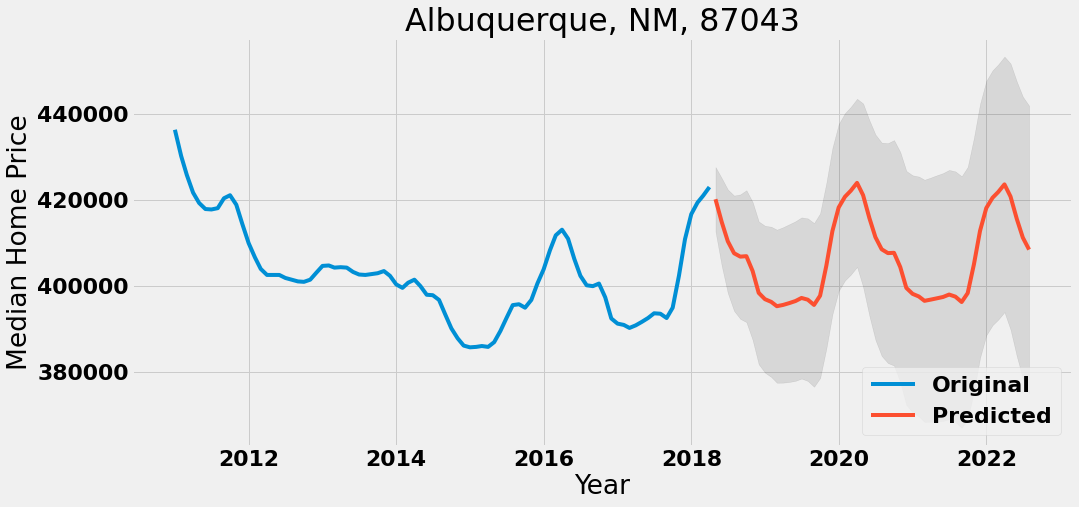

Albuquerque, NM, 87043:
95% confidence between: $375097.0 and $441879.0
Confidence range: $66782.0


In [35]:
#Define SARIMAX model and fit data save as sarima_mod5
sarima_mod5 = sm.tsa.statespace.SARIMAX(abq_df_new[87043],
                                        order=(1, 0, 0), 
                                        seasonal_order=(1, 1, 0, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False).fit()
# Forecast 52 months into the future (4 years)
forecast5 = sarima_mod5.get_forecast(steps=52).summary_frame()
# Calculate the mean of the last week of the forecast as the predicted value
forecast5_mean = round(forecast5['mean'][51])
#Calculate the difference between lower and upper 95% confidence intervals of the last week of the forecast 
low_int5 =  round(forecast5['mean_ci_lower'][51])
high_int5 = round(forecast5['mean_ci_upper'][51])
#Calculate the difference between the upper and lower confidence intervals
ci_delta5 = round(high_int5 - low_int5)

# Plot the original data and predicted values with confidence intervals
fig, ax = plt.subplots(figsize=(15, 7))
plt.plot(abq_df_new[87043])
plt.plot(forecast5['mean'])
ax.fill_between(forecast5.index, forecast5['mean_ci_lower'], 
                    forecast5['mean_ci_upper'], color='k', alpha=0.1)
plt.title('Albuquerque, NM, 87043')
plt.legend(['Original','Predicted'], loc='lower right')
plt.xlabel('Year')
plt.ylabel('Median Home Price')
plt.show()


print(f'Albuquerque, NM, 87043:')
print(f'95% confidence between: ${low_int5} and ${high_int5}')
print(f'Confidence range: ${ci_delta5}')

These results are a lot different compared to the above zipcodes. The 95% confidence level is between $375,097 and $441,879. The confidence range is $66,782. The SARIMAX model seems to perform better for this particular zipcode as well and seems more realistic. Let's examine the residuals.

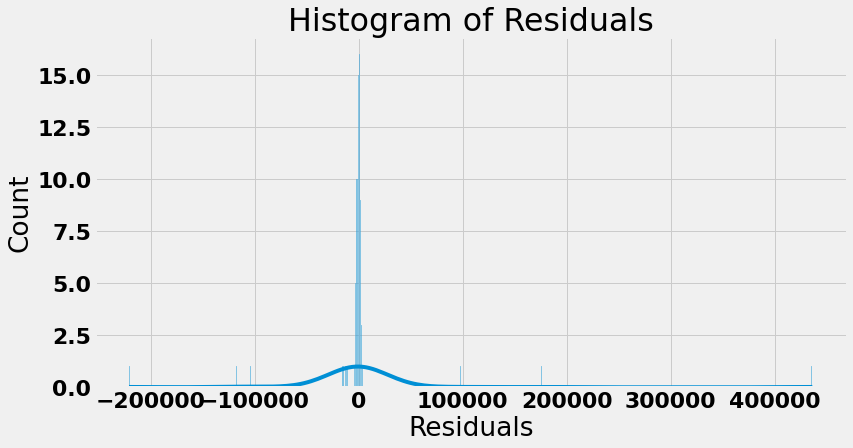

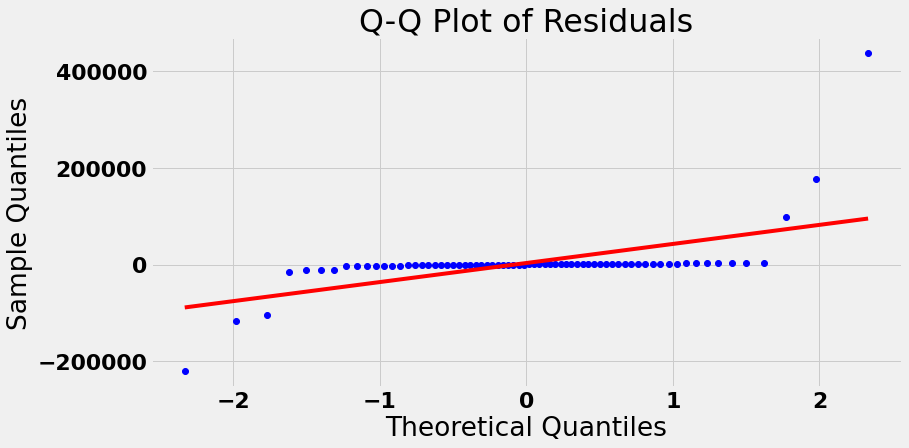

In [36]:
# Residuals
residuals = model5.resid

# Histogram of residuals
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.show()

# Q-Q plot of residuals
plt.figure(figsize=(12, 6))
stats.probplot(residuals, plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

The histogram of residuals looks normally distributed but with some outliers. So it doesn't completely deviate significantly from a normal distribution. The QQ plot curves off and could mean the data has extreme values. 

# Evaluation

Now that I have my models for the top five zipcodes to invest in Albuquerque, I want to see the RMSE, low confidence, high confidence, forecast range and ROI for each of the zipcodes.

In [37]:
# Define a list of zipcodes to include
zipcodes = [87106, 87122, 87104, 87048, 87043]

# Subset the DataFrame to only include rows where the year is 2018 and the zipcode is in the list of zipcodes
abq_df_2018 = abq_df_new.loc[(abq_df_new.index.year == 2018) & (abq_df_new.index.month == 1) & (abq_df_new.index.day == 1), zipcodes]

# Calculate the median of the values for each zipcode in 2018
medians_2018 = abq_df_2018.median()

# Print the results
for zipcode, median in medians_2018.items():
    print(f"The median home value for zipcode {zipcode} in 2018 was ${median:,.2f}")

The median home value for zipcode 87106 in 2018 was $230,500.00
The median home value for zipcode 87122 in 2018 was $508,200.00
The median home value for zipcode 87104 in 2018 was $190,300.00
The median home value for zipcode 87048 in 2018 was $415,000.00
The median home value for zipcode 87043 in 2018 was $416,700.00


In [38]:
# Define lists for the zipcode, city, median value, RMSE, low confidence, high confidence, and forecast range.
zipcodes = ['87106', '87122', '87104', '87048', '87043']
cities = ['Albuquerque, NM','Albuquerque, NM', 'Albuquerque, NM', 'Corrales, NM','Santa Ana Pueblo, NM']
med_values = [230500, 508200, 190300, 415000, 416700]
rmse = [rmse, rmse2, rmse3, rmse4, rmse5]
low_confs = [low_int1, low_int2, low_int3, low_int4, low_int5]
high_confs = [high_int1, high_int2, high_int3, high_int4, high_int5]
forecast_ranges = [ci_delta1, ci_delta2, ci_delta3, ci_delta4, ci_delta5]

# Create a dictionary 'abq' that contains the zipcode, city, median value, RMSE, low confidence, high confidence, and forecast range.
abq = {'Zipcode': zipcodes,
        'City': cities,
        '2018 median value': med_values,
        'rmse': rmse,
        'low_conf': low_confs,
        'high_conf': high_confs,
        'forecast range': forecast_ranges}

# Create a DataFrame 'df_results' using the dictionary 'abq'.
df_results = pd.DataFrame(data=abq)

# Calculate the low and high ends of the confidence interval for each row, and store the results in new columns 'low_end' and 'high_end'.
df_results['low_end'] = df_results['2018 median value'] + df_results['low_conf']
df_results['high_end'] = df_results['2018 median value'] + df_results['high_conf']

# Calculate the ROI percentage for each row, and store the results in a new column 'ROI%'.
df_results['ROI%'] = round(((df_results['high_end'] - df_results['2018 median value']) /
                                      df_results['2018 median value']) * 100, 2)

In [39]:
df_results

,Zipcode,City,2018 median value,rmse,low_conf,high_conf,forecast range,low_end,high_end,ROI%
0,87106,"Albuquerque, NM",230500,28566.613682,236629.0,293381.0,56752.0,467129.0,523881.0,127.28
1,87122,"Albuquerque, NM",508200,4276.872528,465108.0,543586.0,78478.0,973308.0,1051786.0,106.96
2,87104,"Albuquerque, NM",190300,6118.499377,202629.0,239505.0,36876.0,392929.0,429805.0,125.86
3,87048,"Corrales, NM",415000,16113.137999,447569.0,581744.0,134175.0,862569.0,996744.0,140.18
4,87043,"Santa Ana Pueblo, NM",416700,16992.337405,375097.0,441879.0,66782.0,791797.0,858579.0,106.04


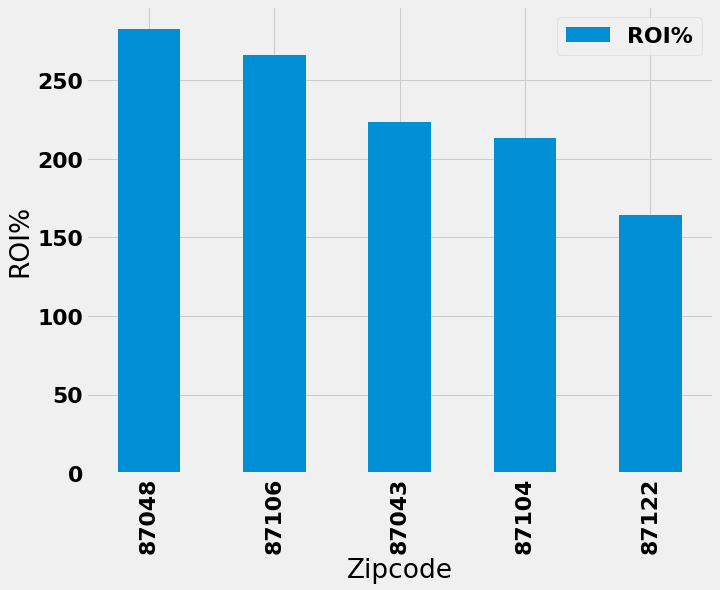

In [40]:
# create a DataFrame from the given data
data = {'zipcode': ['87106', '87122', '87104', '87048', '87043'],
        'city': ['Albuquerque, NM', 'Albuquerque, NM', 'Albuquerque, NM', 'Corrales, NM', 'Santa Ana Pueblo, NM'],
        '2018 median value': [230500, 508200, 190300, 415000, 416700],
        'rmse': [31455.188774, 81866.138297, 25140.743922, 56009.750599, 71678.384869],
        'low_conf': [43008, 52707, 134725, -68970, 200748],
        'high_conf': [612761, 833727, 405455, 1173814, 930335],
        'forecast range': [569753, 781020, 270730, 1242784, 729587],
        'low_end': [273508, 560907, 325025, 346030, 617448],
        'high_end': [843261, 1341927, 595755, 1588814, 1347035],
        'ROI%': [265.84, 164.05, 213.06, 282.85, 223.26]}
df = pd.DataFrame(data)

# sort the DataFrame by the ROI% column
df = df.sort_values('ROI%', ascending=False)

# plot the ROI values as a bar chart
ax = df.plot(x='zipcode', y='ROI%', kind='bar', figsize=(10, 8))
ax.set_xticklabels(df['zipcode'])
ax.set_xlabel('Zipcode')
ax.set_ylabel('ROI%')
plt.show()

These results are showing the predicted median home value, the root mean squared error (RMSE), the low and high confidence intervals for the predicted median home value, the forecast range (high value minus low value), the low and high end values of the predicted range, and the ROI% for five different zip codes. 

The low and high confidence intervals represent the range within which the true median home value is expected to fall with a 95% confidence level. The forecast range is the difference between the high and low values of the predicted median home value range. The ROI represents the return on investment for each zipcode. 

# Recommendations

For those who are intersted investing in properties in New Mexico, there are the following zipcodes that has a high return on investment. 

1. Corrales, NM (87048) 
2. Albuquerque, NM (87106) 
3. Santa Ana Pueblo, NM (87043) - Santa Ana Pubelo's median value in 2018 was $416,700 and forecasted a confidence range between $375,097 and $441,8790.
4. Albuquerque, NM (87104)
5. Albuquerque, NM (87122)

The model's inability to generate realistic forecasts resulted in identical forecast ranges for zipcodes 87048, 87106, 87104, and 87122. However, analyzing the ROI paints a different picture. Investors seeking property in New Mexico would be better off considering Corrales or Santa Ana Pueblo. A 2023 Zillow search revealed that Santa Ana Pueblo's home prices range from $200,000 to $1,795,950, while Corrales' prices range from $205,000 to $3,800,000. These wide ranges suggest that further investigation of these zipcodes could reveal intriguing insights.

# Next Steps

1. Further investigation into Santa Ana Pueblo and Corrales. 
2. Include external factors that may influence real estate prices, such as population growth or unemployment rates.
3. Investigate rapidly growing neighborhoods in New Mexico.